# Введение

## Цель проекта

разработать модель машинного обучения для предсказания судьбы стартапов

## Загрузка библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures #, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from fuzzywuzzy import fuzz, process
import pycountry_convert as pc


RANDOM_STATE = 42

In [5]:
!pip install phik

import phik

In [6]:
!pip install shap
import shap


In [7]:
!pip install lightgbm
from lightgbm import LGBMClassifier

In [8]:
!pip install catboost
from catboost import CatBoostClassifier


# 1. Загрузка и ознакомление с данными

In [10]:
train_data = pd.read_csv('C:/Users/levle/OneDrive/Documents/Yandex_Practicum_main/Master1/M1_DS - Startups (STD)/kaggle_startups_train_28062024.csv', sep=',')
test_data = pd.read_csv('C:/Users/levle/OneDrive/Documents/Yandex_Practicum_main/Master1/M1_DS - Startups (STD)/kaggle_startups_test_28062024.csv', sep=',')

In [11]:
train_data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [12]:
test_data.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


## Вывод

Данные загруженны, проблем с разделителем нет

# 2. Предварительная обработка

## train data

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [17]:
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], errors='coerce')
train_data['first_funding_at'] = pd.to_datetime(train_data['first_funding_at'], errors='coerce')
train_data['last_funding_at'] = pd.to_datetime(train_data['last_funding_at'], errors='coerce')

In [18]:
train_data.describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at
count,4.244700e+04,52516.000000,52516,52516,52516
mean,1.824748e+07,1.740670,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00
25%,3.360275e+05,1.000000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00
std,1.871173e+08,1.374522,NaN,NaN,NaN


In [19]:
train_data['funding_total_usd'].max()

30079503000.0

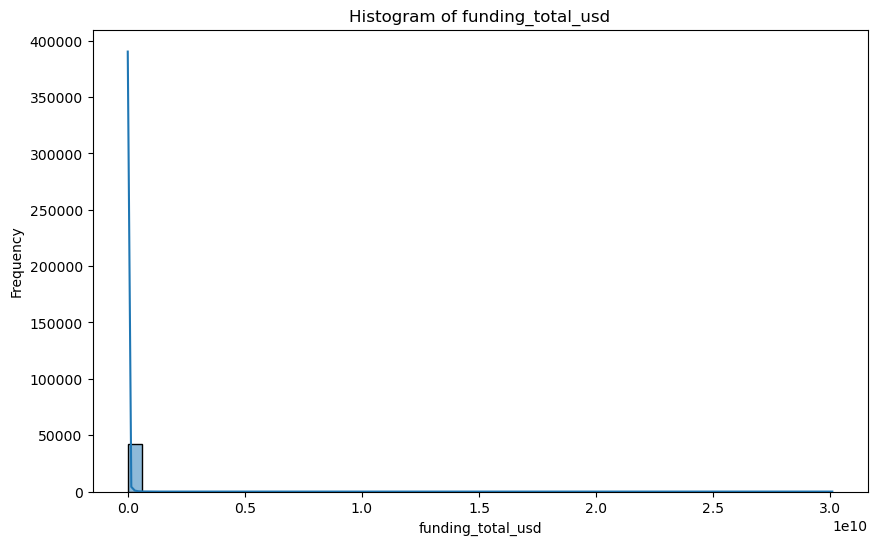

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['funding_total_usd'], bins=50, kde=True)
plt.title('Histogram of funding_total_usd')
plt.xlabel('funding_total_usd')
plt.ylabel('Frequency')
plt.show()

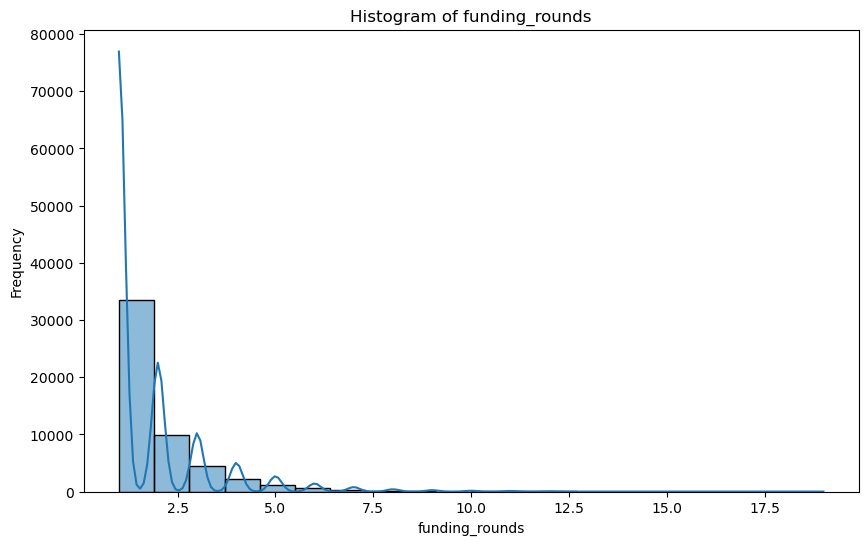

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['funding_rounds'], bins=20, kde=True)
plt.title('Histogram of funding_rounds')
plt.xlabel('funding_rounds')
plt.ylabel('Frequency')
plt.show()

In [22]:
##train_data[train_data['category_list'].isnull()].info()

In [23]:
duplicates = train_data.duplicated()
duplicated_rows = train_data[duplicates]
duplicated_rows.count()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

### Вывод 

есть пропуски, явных дупликатов нет. Видно что есть несколько проектов с очень большим финансированием и большим количеством роундов сбора

с размером финансирования нужно будет что-то делать если стараться оставить всю дату

## test data

In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [27]:
duplicates = test_data.duplicated()
duplicated_rows = test_data[duplicates]
duplicated_rows.count()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [28]:
test_data['first_funding_at'] = pd.to_datetime(test_data['first_funding_at'], errors='coerce')
test_data['last_funding_at'] = pd.to_datetime(test_data['last_funding_at'], errors='coerce')

In [29]:
test_data.describe()

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime
count,1.054700e+04,13125.000000,13125,13125,13125.000000
mean,1.654910e+07,1.714438,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392,3097.609524
min,1.000000e+00,1.000000,1973-04-15 00:00:00,1973-04-15 00:00:00,52.000000
25%,3.200000e+05,1.000000,2009-11-16 00:00:00,2011-01-10 00:00:00,1726.000000
50%,2.000000e+06,1.000000,2012-08-01 00:00:00,2013-08-21 00:00:00,2526.000000
75%,1.000000e+07,2.000000,2014-04-01 00:00:00,2014-11-11 00:00:00,3866.000000
max,4.715000e+09,15.000000,2015-12-03 00:00:00,2015-12-12 00:00:00,17167.000000
std,9.217283e+07,1.318800,NaN,NaN,2128.356554


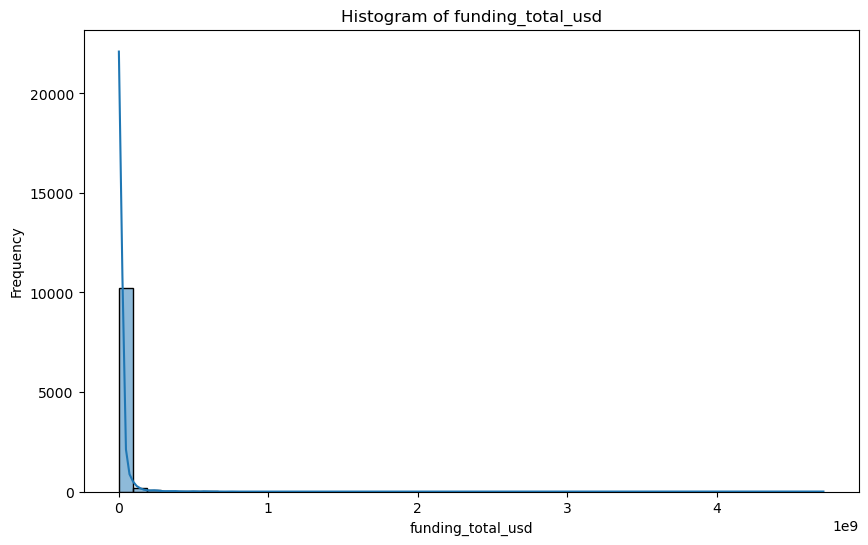

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data['funding_total_usd'], bins=50, kde=True)
plt.title('Histogram of funding_total_usd')
plt.xlabel('funding_total_usd')
plt.ylabel('Frequency')
plt.show()

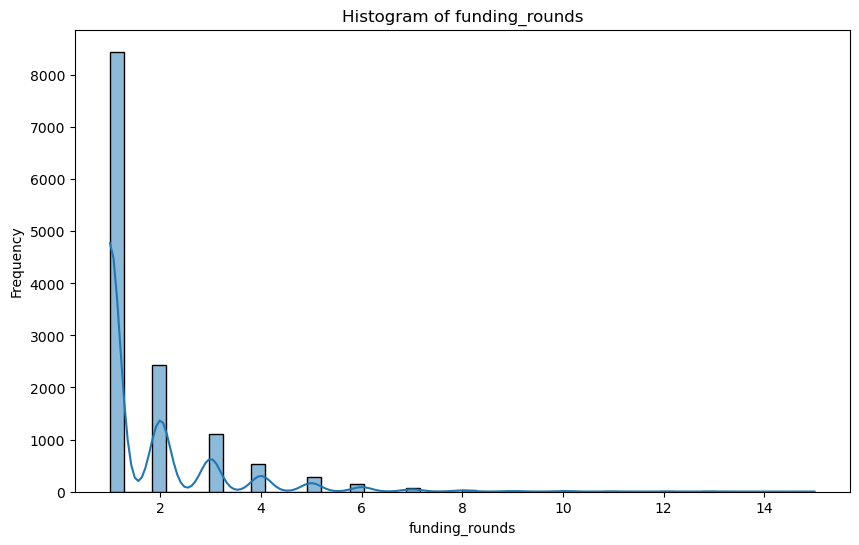

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data['funding_rounds'], bins=50, kde=True)
plt.title('Histogram of funding_rounds')
plt.xlabel('funding_rounds')
plt.ylabel('Frequency')
plt.show()

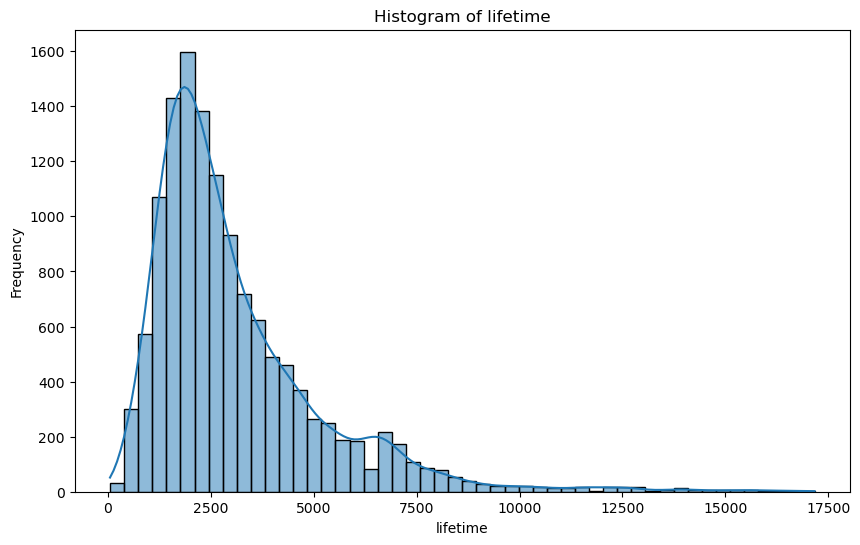

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data['lifetime'], bins=50, kde=True)
plt.title('Histogram of lifetime')
plt.xlabel('lifetime')
plt.ylabel('Frequency')
plt.show()

### Вывод 

есть пропуски, явных дупликатов нет. Видно что есть несколько проектов с очень большим финансированием и большим количеством роундов сбора

с размером финансирования нужно будет что-то делать если стараться оставить всю дату

## Заполнение пропущенных колонок

train_data has status, founded_at, and closed_at, which are missing in test_data.

test_data has lifetime, which is missing in train_data.

Статус это таргет

Founded_at можно высчитать используя lifetime в test_data

lifetime с помощью founded_at в train_data

In [36]:
train_data['extract_date'] = pd.to_datetime('2018-01-01')

In [37]:
test_data['extract_date'] = pd.to_datetime('2018-01-01')

In [38]:
train_data['founded_at'] = pd.to_datetime(train_data['founded_at'], errors='coerce')

In [39]:
train_data['lifetime'] = np.where(
    train_data['closed_at'].isnull(),
    (train_data['extract_date'] - train_data['founded_at']).dt.days,  # If closed_at is null, use extract_date
    (pd.to_datetime(train_data['closed_at']) - train_data['founded_at']).dt.days  # Otherwise, use closed_at
)

In [40]:
test_data['founded_at'] = test_data['extract_date'] - pd.to_timedelta(test_data['lifetime'], unit='D')

In [41]:
test_data['source'] = 'test_data'
train_data['source'] = 'train_data'

# 3. Чистка, обработка пропусков и создание синтетических признаков

In [43]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [44]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               65640 non-null  object        
 1   category_list      62585 non-null  object        
 2   funding_total_usd  52994 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       58757 non-null  object        
 5   state_code         57183 non-null  object        
 6   region             57693 non-null  object        
 7   city               57695 non-null  object        
 8   funding_rounds     65641 non-null  int64         
 9   founded_at         65641 non-null  datetime64[ns]
 10  first_funding_at   65641 non-null  datetime64[ns]
 11  last_funding_at    65641 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
 13  extract_date       65641 non-null  datetime64[ns]
 14  lifeti

In [45]:
combined_data['category_list'] = combined_data['category_list'].fillna('unknown')

In [46]:
combined_data['status'] = np.where(
    (combined_data['status'].isnull()) & (combined_data['source'] == 'train_data'),
    np.where(combined_data['closed_at'].notnull(), 'closed', 'operating'),
    combined_data['status']
)

In [47]:
combined_data['country_code'] = combined_data['country_code'].fillna('unknown')
combined_data['state_code'] = combined_data['state_code'].fillna('unknown')
combined_data['region'] = combined_data['region'].fillna('unknown')
combined_data['city'] = combined_data['city'].fillna('unknown')


In [48]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               65640 non-null  object        
 1   category_list      65641 non-null  object        
 2   funding_total_usd  52994 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       65641 non-null  object        
 5   state_code         65641 non-null  object        
 6   region             65641 non-null  object        
 7   city               65641 non-null  object        
 8   funding_rounds     65641 non-null  int64         
 9   founded_at         65641 non-null  datetime64[ns]
 10  first_funding_at   65641 non-null  datetime64[ns]
 11  last_funding_at    65641 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
 13  extract_date       65641 non-null  datetime64[ns]
 14  lifeti

In [49]:
combined_data[combined_data['funding_total_usd'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,extract_date,lifetime,source
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2018-01-01,2791.0,train_data
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN,2018-01-01,3287.0,train_data
16,Salesjob,unknown,NaN,closed,unknown,unknown,unknown,unknown,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11,2018-01-01,952.0,train_data
24,Savasti,unknown,NaN,closed,unknown,unknown,unknown,unknown,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03,2018-01-01,672.0,train_data
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaN,2018-01-01,3949.0,train_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65624,Thumb Friendly,Mobile,NaN,NaN,USA,GA,Atlanta,Atlanta,1,2011-10-01,2013-03-07,2013-03-07,NaN,2018-01-01,2284.0,test_data
65626,"Bloomz, Inc.",Education|Information Technology|Mobile Softwa...,NaN,NaN,USA,WA,Seattle,Redmond,3,2014-01-01,2014-01-22,2015-11-13,NaN,2018-01-01,1461.0,test_data
65629,The Fabulous,Apps,NaN,NaN,FRA,A8,Paris,Paris,1,2014-07-08,2015-03-09,2015-03-09,NaN,2018-01-01,1273.0,test_data
65630,VIPTALON,Discounts|Fashion|Shopping,NaN,NaN,RUS,48,Moscow,Moscow,1,2011-01-13,2011-01-13,2011-01-13,NaN,2018-01-01,2545.0,test_data


### TF-IDF + KMeans кластеринг

In [51]:
##vectorizer = TfidfVectorizer(stop_words='english')
##tfidf_matrix = vectorizer.fit_transform(combined_data['category_list'])

In [52]:
##n_clusters = 20 
##kmeans = KMeans(n_clusters=n_clusters, random_state=42)
##combined_data['category_cluster'] = kmeans.fit_predict(tfidf_matrix)

In [53]:
##unique_combinations = combined_data[['category_cluster', 'category_list']].drop_duplicates()

In [54]:
##unique_combinations.head(50)

### first category

In [56]:
combined_data['first_category'] = combined_data['category_list'].str.split('|').str[0].str.lower()


In [57]:
unique_categories = combined_data['first_category'].dropna().unique().tolist()


In [58]:
threshold = 90  # Similarity threshold
matches = {}

for category in unique_categories:
    # Extract similar categories with scores
    match_list = process.extract(category, unique_categories, limit=None, scorer=fuzz.partial_ratio)
    
    for match, score in match_list:
        if score >= threshold and category != match:
            # Add the match to the dictionary
            if category not in matches:
                matches[category] = []
            matches[category].append((match, score))


In [59]:
category_mapping = {}

for main_category, similar_categories in matches.items():
    # Get the frequency of each category
    frequencies = combined_data['first_category'].value_counts()
    
    # Select the most frequent category to be the main one
    best_match = max([main_category] + [match for match, score in similar_categories],
                     key=lambda x: frequencies.get(x, 0))
    
    # Map all similar categories to the main category
    for match, score in similar_categories:
        category_mapping[match] = best_match
    category_mapping[main_category] = best_match  # Include the main category itself


In [60]:
combined_data['standardized_category'] = combined_data['first_category'].map(category_mapping).fillna(combined_data['first_category'])

In [61]:
combined_data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,extract_date,lifetime,source,first_category,standardized_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2018-01-01,2998.0,train_data,online reservations,online reservations
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,2018-01-01,4748.0,train_data,manufacturing,manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,2018-01-01,4383.0,train_data,biotechnology,biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,NaN,2018-01-01,5114.0,train_data,health care,health care
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2018-01-01,2791.0,train_data,manufacturing,manufacturing


### Word Embeddings + Clustering

In [63]:
category_tokens = combined_data['standardized_category'].str.split('|').tolist()

In [64]:
w2v_model = Word2Vec(category_tokens, vector_size=100, window=5, min_count=1, sg=1)

In [65]:
def get_category_vector(category):
    words = category.split('|')
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(100)  

combined_data['category_vector'] = combined_data['standardized_category'].apply(get_category_vector)

In [66]:
category_matrix = np.stack(combined_data['category_vector'].values)
kmeans = KMeans(n_clusters=20, random_state=42)
combined_data['category_cluster'] = kmeans.fit_predict(category_matrix)

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [67]:
unique_combinations = combined_data[['category_cluster', 'standardized_category']].drop_duplicates()

In [68]:
centroids = kmeans.cluster_centers_

def closest_words_to_centroid(centroid, model, top_n=10):
    word_vectors = model.wv
    closest_words = word_vectors.similar_by_vector(centroid, topn=top_n)
    return [word for word, similarity in closest_words]

top_words_per_cluster = []
for centroid in centroids:
    top_words = closest_words_to_centroid(centroid, w2v_model)
    top_words_per_cluster.append(top_words)

for idx, words in enumerate(top_words_per_cluster):
    print(f"Cluster {idx}: {words}")

Cluster 0: ['unknown', 'crowdsourcing', 'mhealth', 'senior health', 'rental housing', 'p2p money transfer', 'b2b', 'mobility', 'leisure', 'digital media']
Cluster 1: ['biotechnology', 'venture capital', 'console gaming', 'carbon', 'gps', 'freelancers', 'recycling', 'certification test', 'limousines', 'commodities']
Cluster 2: ['clean technology', 'business services', 'consumer goods', 'design', 'group buying', 'video', 'consumer lending', 'usability', 'subscription businesses', 'biomass power generation']
Cluster 3: ['curated web', 'automotive', 'energy', 'android', 'application platforms', 'enterprises', 'specialty foods', 'soccer', 'm2m', 'mobility']
Cluster 4: ['software', 'group buying', 'events', 'drones', 'craft beer', 'facebook applications', 'advice', 'internet', 'health care', 'employer benefits programs']
Cluster 5: ['analytics', 'consulting', 'natural language processing', 'translation', 'bioinformatics', 'soccer', 'online gaming', 'banking', 'energy', 'skill gaming']
Cluste

### Continent

In [70]:
def country_to_continent(country_code):
    try:
        # Convert 3-letter country code to 2-letter
        country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
        # Convert 2-letter country code to continent code (AF, EU, NA, etc.)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        # Map continent codes to continent names
        continent_name = {
            'AF': 'Africa',
            'NA': 'North America',
            'OC': 'Oceania',
            'AN': 'Antarctica',
            'AS': 'Asia',
            'EU': 'Europe',
            'SA': 'South America'
        }
        return continent_name[continent_code]
    except KeyError:
        return 'Unknown'

# Apply the function to the 'country_code' column
combined_data['continent'] = combined_data['country_code'].apply(country_to_continent)

### Синтетика и заполнение сложных пропусков

In [72]:
combined_data['funding_rounds_capped'] = combined_data['funding_rounds'].clip(upper=6)

In [73]:
combined_data['founded_year'] = combined_data['founded_at'].dt.year

In [74]:
combined_data['founded_month'] = combined_data['founded_at'].dt.month

In [75]:
combined_data['years_founded_to_last_funding'] = (combined_data['last_funding_at'].dt.year - combined_data['founded_at'].dt.year)

In [76]:
combined_data['days_first_to_last_funding'] = (combined_data['last_funding_at'] - combined_data['first_funding_at']).dt.days

In [77]:
combined_data['days_last_funding_to_extract_date'] = (combined_data['extract_date'] - combined_data['last_funding_at']).dt.days

In [78]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   name                               65640 non-null  object        
 1   category_list                      65641 non-null  object        
 2   funding_total_usd                  52994 non-null  float64       
 3   status                             52516 non-null  object        
 4   country_code                       65641 non-null  object        
 5   state_code                         65641 non-null  object        
 6   region                             65641 non-null  object        
 7   city                               65641 non-null  object        
 8   funding_rounds                     65641 non-null  int64         
 9   founded_at                         65641 non-null  datetime64[ns]
 10  first_funding_at                  

# changed category_cluster to be continent in fixing of funding

# removed founded_year and added standardized category

In [81]:
combined_data['avg_funding_per_name_per_round'] = combined_data['funding_total_usd']/combined_data['funding_rounds']

In [82]:
median_funding = combined_data.groupby(['standardized_category', 'continent'])['avg_funding_per_name_per_round'].median().reset_index()

In [83]:
combined_data = pd.merge(combined_data, median_funding, on=['continent', 'standardized_category' ], suffixes=('', '_median'))

In [84]:
combined_data['funding_total_usd'].fillna(combined_data['avg_funding_per_name_per_round_median'], inplace=True)

In [85]:
combined_data.drop(columns=['avg_funding_per_name_per_round_median'], inplace=True)

ещё остались пропуски....

In [87]:
median_funding_year = combined_data.groupby(['founded_year'])['avg_funding_per_name_per_round'].median().reset_index()

In [88]:
combined_data = pd.merge(combined_data, median_funding_year, on=['founded_year'], suffixes=('', '_median_year'))

In [89]:
combined_data['funding_total_usd'].fillna(combined_data['avg_funding_per_name_per_round_median_year'], inplace=True)

In [90]:
combined_data.drop(columns=['avg_funding_per_name_per_round_median_year'], inplace=True)

In [91]:
combined_data['avg_funding_per_name_per_round'] = combined_data['funding_total_usd']/combined_data['funding_rounds']

In [92]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65641 entries, 0 to 65640
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   name                               65640 non-null  object        
 1   category_list                      65641 non-null  object        
 2   funding_total_usd                  65641 non-null  float64       
 3   status                             52516 non-null  object        
 4   country_code                       65641 non-null  object        
 5   state_code                         65641 non-null  object        
 6   region                             65641 non-null  object        
 7   city                               65641 non-null  object        
 8   funding_rounds                     65641 non-null  int64         
 9   founded_at                         65641 non-null  datetime64[ns]
 10  first_funding_at                  

### funding_total_usd ранки

In [94]:

combined_data['funding_rank_per_year'] = combined_data.groupby(['continent', 'category_cluster', 'founded_year'])['funding_total_usd'].transform(
    lambda x: x.rank(pct=True)
)


combined_data['funding_percentile_category_per_year'] = pd.cut(
    combined_data['funding_rank_per_year'],
    bins=[0, 0.33, 0.66, 1], 
    labels=['Low', 'Medium', 'High']  
)


print(combined_data[['continent', 'funding_total_usd', 'category_cluster', 'founded_year', 'funding_percentile_category_per_year']].head())


       continent  funding_total_usd  category_cluster  founded_year  \
0         Europe           828626.0                14          2009   
1  North America           200000.0                 7          2009   
2  North America           300000.0                 7          2009   
3  North America          9500000.0                 7          2009   
4  North America         67000000.0                 7          2009   

  funding_percentile_category_per_year  
0                               Medium  
1                                  Low  
2                                  Low  
3                                 High  
4                                 High  


In [95]:
train_data_v2 = combined_data[combined_data['source'] == 'train_data']
test_data_v2 = combined_data[combined_data['source'] == 'test_data']

In [96]:
#test_data_v2.drop(columns=['category_list', 'closed_at', 'status', 'source', 'name'], inplace=True)

# 4. Корреляционный анализ цифровых признаков

In [98]:
#train_data_v2.drop(columns=['closed_at','source', 'category_list', 'name', ], inplace=True)

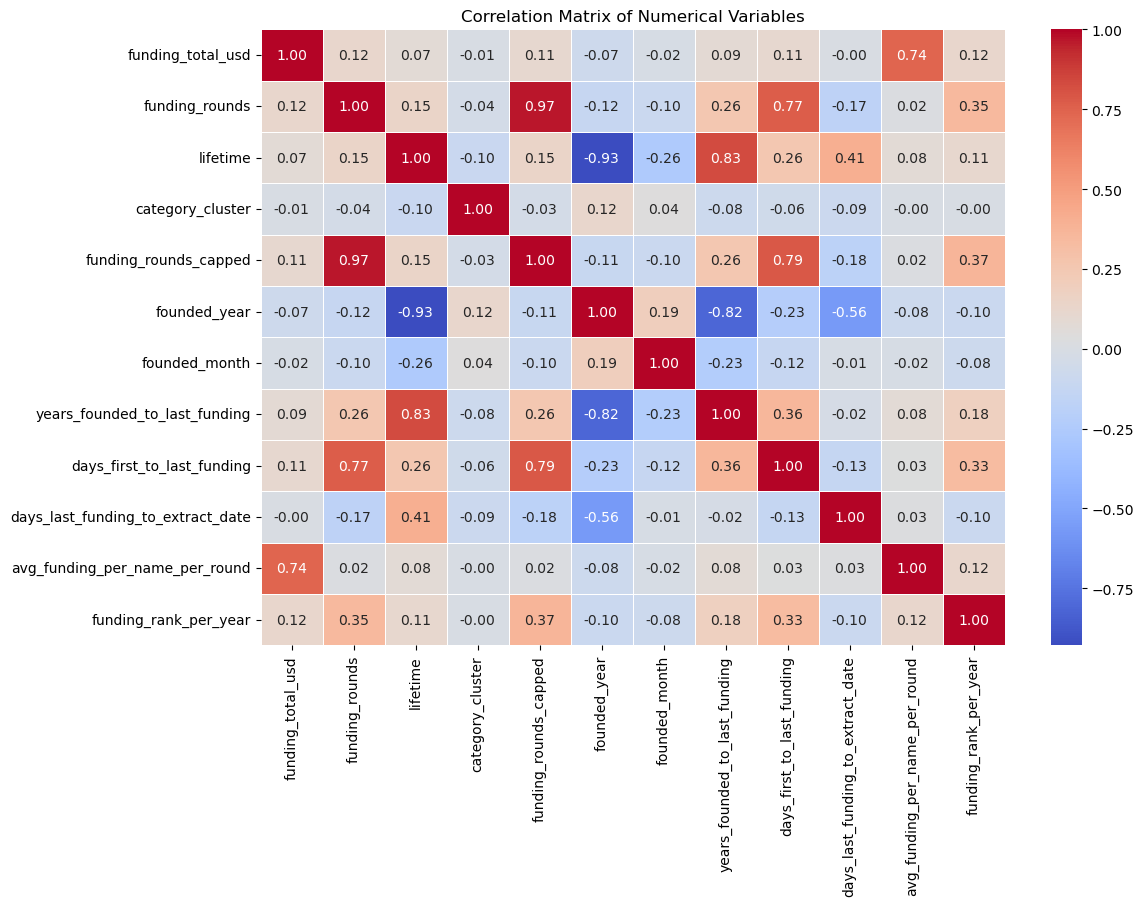

In [99]:
numeric_columns = train_data_v2.select_dtypes(include=['float64', 'int64', 'int32'])
corr_matrix = numeric_columns.corr(method='pearson')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## Вывод

funding_total_usd & avg_funding_per_name_per_round - это ожидаемо учитывая что большинство компаний имеет только один раунд

funding_rounds & funding_rounds_capped - это ожидаемо и при выборе фаторов для можели останеться только один (впринципе на этот фактор можно смотреть как и на категориальный)

lifetime & founded_year - чем старше компания тем дольше она живёт. обьяснимо. вприцнипе lifetime это синтетический признак из целевого и при моделировании использован не будет


# 5. Анализ категориальных признаков

In [103]:
train_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, 0 to 65640
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   name                                  52515 non-null  object        
 1   category_list                         52516 non-null  object        
 2   funding_total_usd                     52516 non-null  float64       
 3   status                                52516 non-null  object        
 4   country_code                          52516 non-null  object        
 5   state_code                            52516 non-null  object        
 6   region                                52516 non-null  object        
 7   city                                  52516 non-null  object        
 8   funding_rounds                        52516 non-null  int64         
 9   founded_at                            52516 non-null  datetime64[ns]
 10  fir

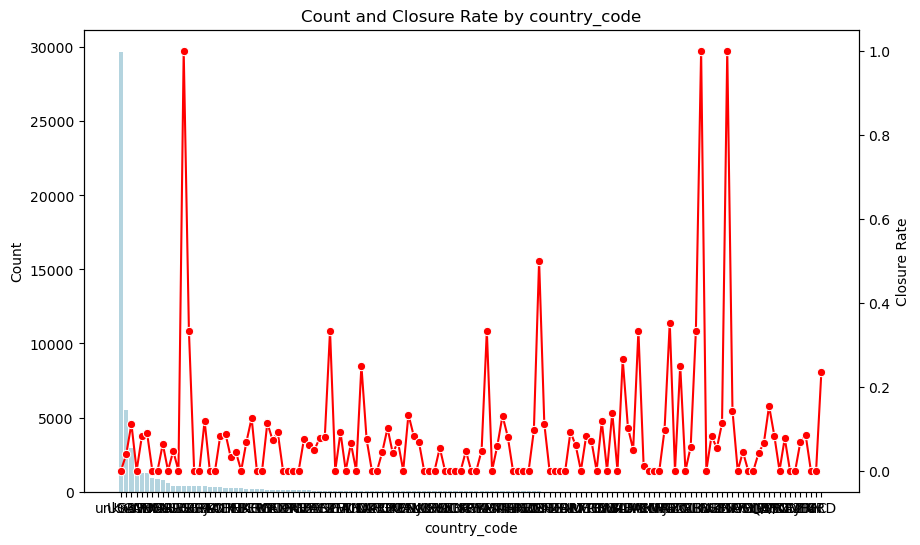

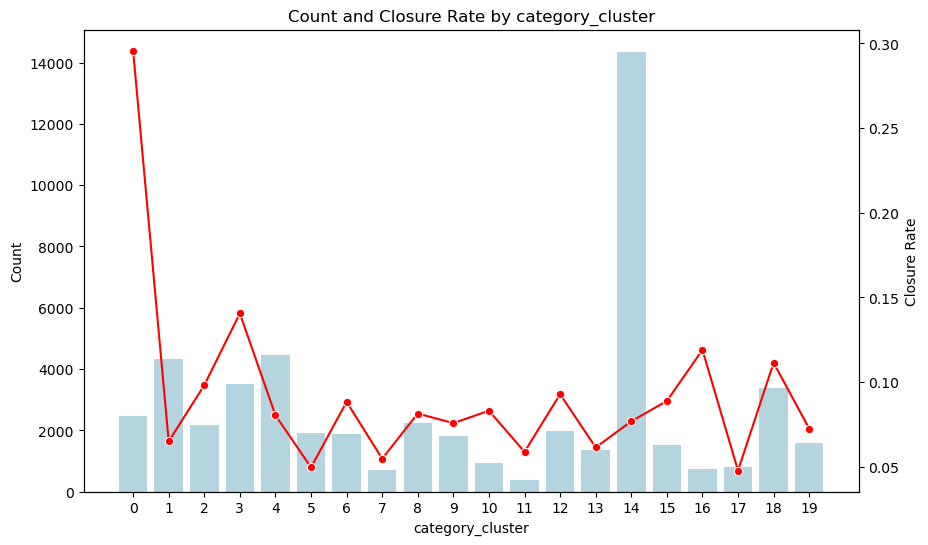

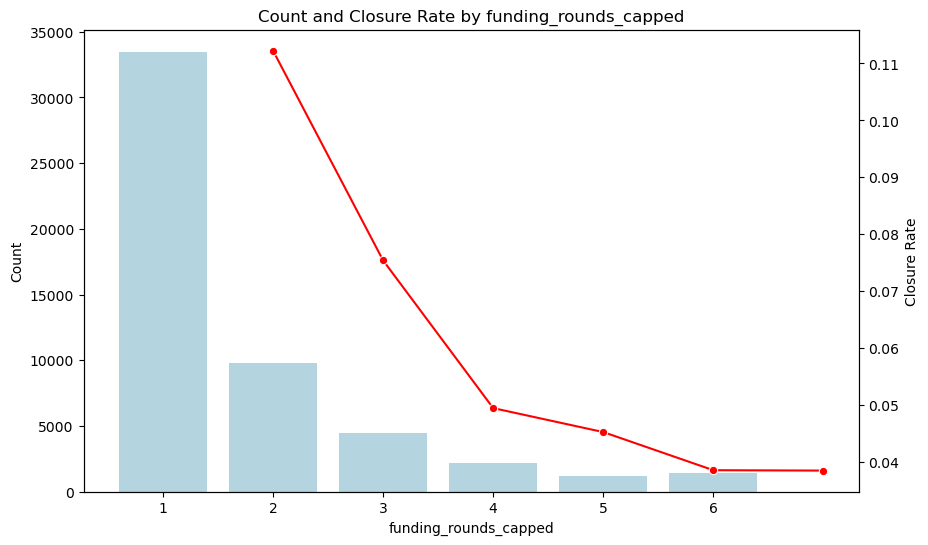

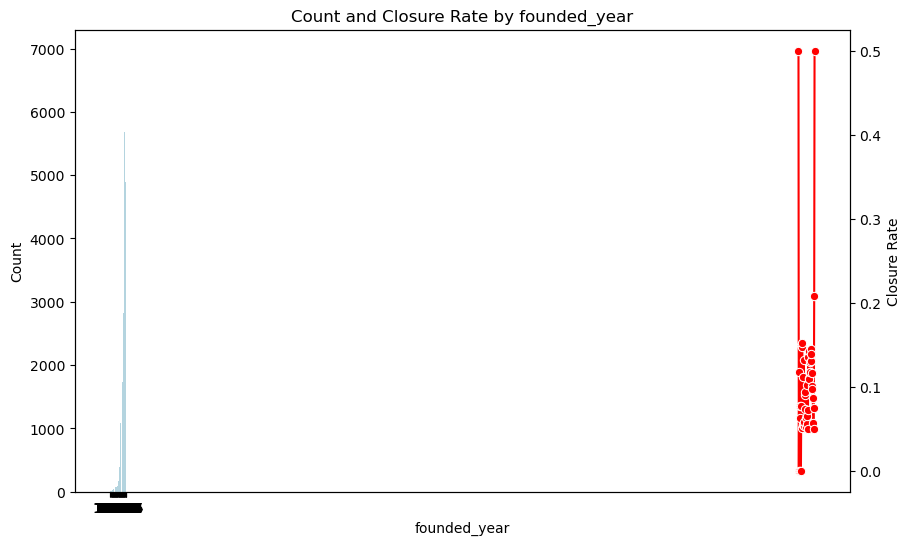

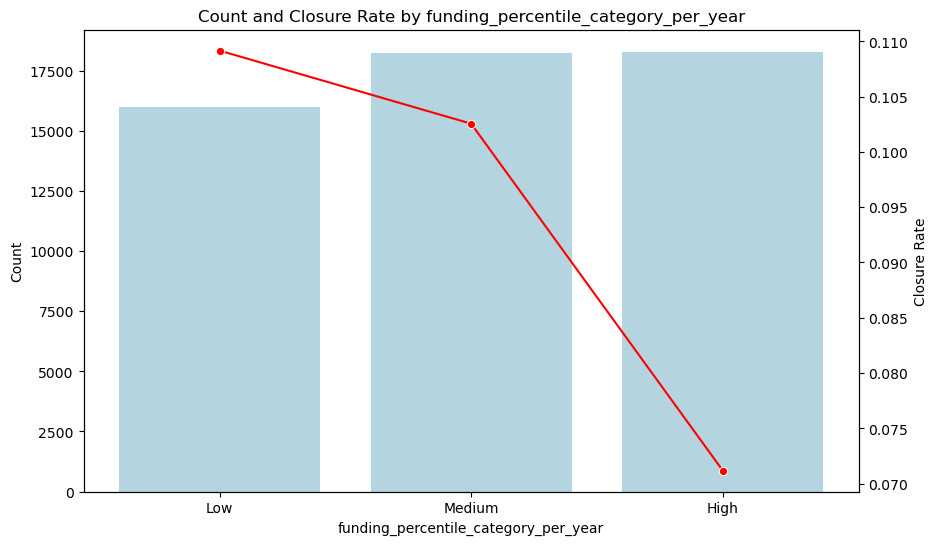

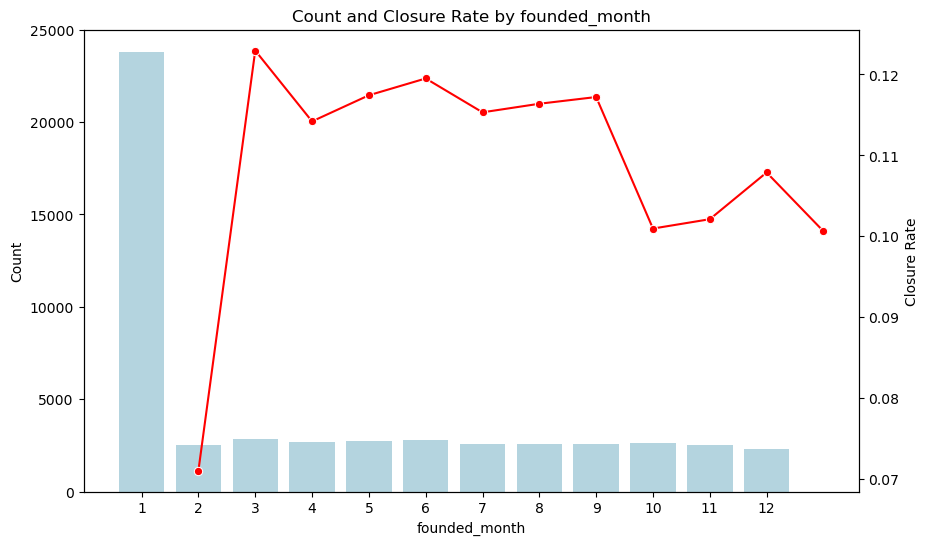

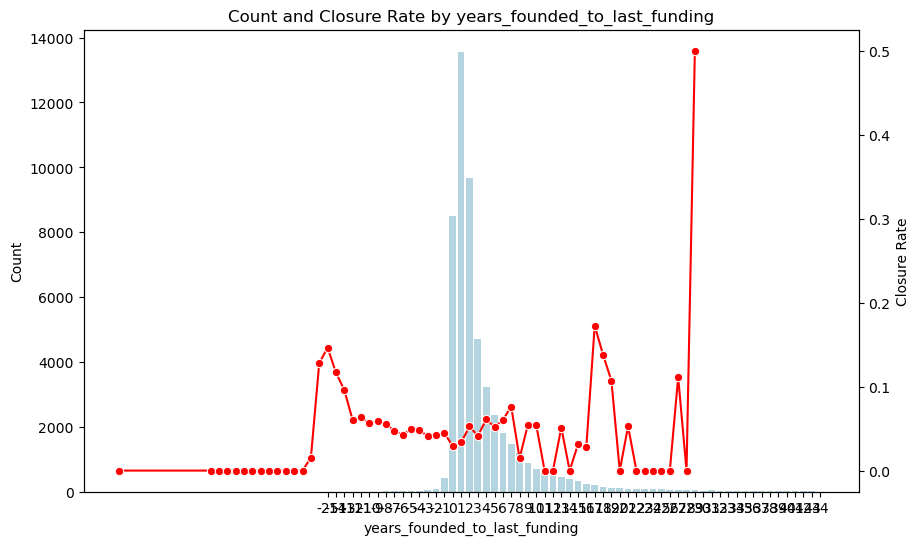

In [104]:
columns_to_plot = ['country_code', 'category_cluster', 'funding_rounds_capped', 'founded_year', 'funding_percentile_category_per_year', 'founded_month', 'years_founded_to_last_funding']

for col in columns_to_plot:
    closure_rate = train_data_v2.groupby(col)['status'].apply(lambda x: (x == 'closed').mean()).reset_index()
    closure_rate.columns = [col, 'closure_rate']
    count_data = train_data_v2[col].value_counts().reset_index()
    count_data.columns = [col, 'count']
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    sns.barplot(data=count_data, x=col, y='count', ax=ax1, color='lightblue')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Count and Closure Rate by {col}')
    
    ax2 = ax1.twinx()
    
    sns.lineplot(data=closure_rate, x=col, y='closure_rate', marker='o', color='red', ax=ax2)
    ax2.set_ylabel('Closure Rate')

    plt.xticks(rotation=45)
    
    plt.show()

In [105]:
closure_rate_grouped = train_data_v2.groupby('founded_year').agg(
    count=('status', 'size'),
    closure_rate=('status', lambda x: (x == 'closed').mean())
).reset_index()
closure_rate_grouped

,founded_year,count,closure_rate
0,1970,2,0.500000
1,1971,13,0.000000
2,1972,17,0.117647
3,1973,13,0.076923
4,1974,11,0.000000
5,1975,16,0.062500
6,1976,20,0.150000
7,1977,18,0.000000
8,1978,26,0.076923
9,1979,39,0.051282


# 6. Отбор финального набора обучающих признаков

In [107]:
train_data_v3 = train_data_v2.drop(['name', 'category_list', 'founded_at', 'first_funding_at', 'last_funding_at', 
                                    'closed_at', 'extract_date', 'source', 'category_vector', 'funding_rounds', 
                                    'funding_rank_per_year',  'state_code', 'region', 'city',
                                    'days_last_funding_to_extract_date','years_founded_to_last_funding', 'avg_funding_per_name_per_round',
                                   'first_category', 'founded_month', 'founded_year', 'country_code'], axis=1) 

In [108]:
test_data_v3 = test_data_v2.drop(['category_list', 'status', 'founded_at', 'first_funding_at', 'last_funding_at', 
                                    'closed_at', 'extract_date', 'source', 'category_vector', 'funding_rounds', 
                                    'funding_rank_per_year', 'state_code', 'region', 'city', 
                                  'days_last_funding_to_extract_date','years_founded_to_last_funding', 'avg_funding_per_name_per_round',
                                 'first_category', 'founded_month', 'founded_year','country_code'], axis=1) 

In [109]:
train_data_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, 0 to 65640
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   funding_total_usd                     52516 non-null  float64 
 1   status                                52516 non-null  object  
 2   lifetime                              52516 non-null  float64 
 3   standardized_category                 52516 non-null  object  
 4   category_cluster                      52516 non-null  int32   
 5   continent                             52516 non-null  object  
 6   funding_rounds_capped                 52516 non-null  int64   
 7   days_first_to_last_funding            52516 non-null  int64   
 8   funding_percentile_category_per_year  52516 non-null  category
dtypes: category(1), float64(2), int32(1), int64(2), object(3)
memory usage: 3.5+ MB


In [110]:
train_data_v3['funding_percentile_category_per_year'].unique()

['Medium', 'Low', 'High']
Categories (3, object): ['Low' < 'Medium' < 'High']

In [111]:
#dsfgsg

# 7. Выбор и обучение моделей

### Пайплайн

In [114]:
#ohe_columns = ['country_code', 'state_code', 'region', 'city', 'category_cluster', 'founded_year', 'funding_rounds_capped']
ohe_columns = [ 'funding_rounds_capped', 'standardized_category', 'continent', 'category_cluster'] 
ord_columns = ['funding_percentile_category_per_year']
num_columns = ['funding_total_usd', 'lifetime', 'days_first_to_last_funding']


ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['Bottom 25%', '25-50%', '50-75%', 'Top 25%']], handle_unknown='use_encoded_value', unknown_value=-1)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

poly_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

In [115]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns),
    ('poly', poly_pipe, num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Создание выборок

In [117]:
X = train_data_v3.drop(['status'], axis=1)
y = train_data_v3['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [118]:
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training feature set shape: (42012, 8)
Testing feature set shape: (10504, 8)
Training labels shape: (42012,)
Testing labels shape: (10504,)


In [119]:
#X_train.to_csv(r'C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master1\M1_DS - Startups (STD)\X_train.csv', index=False)
#y_train.to_csv(r'C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master1\M1_DS - Startups (STD)\y_train.csv', index=False)

### Сетка параметров для RandomizedSearchCV

In [121]:
param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': range(2, 10),
        'model__max_features': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__penalty': ['l2'],
        'model__C': [0.01, 0.1, 1, 10],  # Regularization parameter
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
#    {
#    'model': [KNeighborsClassifier()],
#    'model__n_neighbors': [3, 5, 7, 9],
#    'model__weights': ['uniform', 'distance'],  # Uniform or weighted distance
#    'model__p': [1, 2],  # Manhattan (p=1) or Euclidean (p=2) distance
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    },
    {
    'model': [LGBMClassifier(random_state=RANDOM_STATE)],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': range(3, 10),
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 1.0],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }, 
#    {
#    'model': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
#    'model__C': [0.1, 1, 10],  # Regularization parameter
#    'model__kernel': ['linear', 'poly', 'rbf'],  # Kernel type
#    'model__gamma': ['scale', 'auto'],  # Kernel coefficient
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    },
    {
    'model': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
    'model__depth': range(3, 10),
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__iterations': [100, 200, 300],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
#    {
#    'model': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
#    'model__n_estimators': [100, 200, 300],
#    'model__max_depth': range(3, 10),
#    'model__max_features': ['auto', 'sqrt', 'log2'],
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    },
#    {
#    'model': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
#    'model__n_estimators': [100, 200, 300],
#    'model__learning_rate': [0.01, 0.1, 0.2],
#    'model__max_depth': range(3, 10),
#    'model__subsample': [0.7, 0.8, 1.0],
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    },
#    {
#    'model': [ExtraTreesClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
#    'model__n_estimators': [100, 200, 300],
#    'model__max_depth': range(3, 10),
#    'model__max_features': ['auto', 'sqrt', 'log2'],
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
#    }



]

### Настройка RandomizedSearchCV

In [123]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [124]:
randomized_search = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring=f1_scorer, random_state=RANDOM_STATE, n_jobs=-1)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['funding_rounds_capped',
                                                                                'standardized_category',
                                                                                'continent',...
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'model': [<catboost.core.CatBoostClassifier object at 0x000001737744A910>],
                                         'model__depth': range(3, 10),
                                         'model__iterations': [100, 200, 300],
                                         'model__learning_rate': [0.01, 0.1,
                                                                  0.2],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [125]:
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
best_model = randomized_search.best_estimator_

In [126]:
best_params

{'preprocessor__num__scaler': 'passthrough',
 'model__learning_rate': 0.2,
 'model__iterations': 300,
 'model__depth': 6,
 'model': <catboost.core.CatBoostClassifier at 0x1737744a910>}

In [127]:
best_score

0.9521435662248796

# 8. Итоговая оценка качества предсказания лучшей модели

Лучшая модель имеет эти параметры:

{'preprocessor__num__scaler': StandardScaler(),
 'model__learning_rate': 0.2,
 'model__iterations': 200,
 'model__depth': 8,
 'model': <catboost.core.CatBoostClassifier at 0x2391b2c8a90>}

 и Ф1 = 0.863

# 9. Анализ важности ее признаков

In [131]:
feature_importances = best_model.named_steps['model'].get_feature_importance()
preprocessor = best_model.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(20)


,Feature,Importance
500,num__lifetime,31.640694
509,poly__lifetime^2,16.546042
504,poly__lifetime,11.950188
507,poly__funding_total_usd lifetime,3.073736
506,poly__funding_total_usd^2,2.988336
503,poly__funding_total_usd,2.535761
501,num__days_first_to_last_funding,2.443751
505,poly__days_first_to_last_funding,2.145794
499,num__funding_total_usd,2.017725
508,poly__funding_total_usd days_first_to_last_fun...,1.853580


## Самыми важными оказались: 

признаки количества денег, сластер категорий 3 и года 2014 2010 2013

# 10. Вывод

In [134]:
test_data_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, 39 to 65638
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   name                                  13125 non-null  object  
 1   funding_total_usd                     13125 non-null  float64 
 2   lifetime                              13125 non-null  float64 
 3   standardized_category                 13125 non-null  object  
 4   category_cluster                      13125 non-null  int32   
 5   continent                             13125 non-null  object  
 6   funding_rounds_capped                 13125 non-null  int64   
 7   days_first_to_last_funding            13125 non-null  int64   
 8   funding_percentile_category_per_year  13125 non-null  category
dtypes: category(1), float64(2), int32(1), int64(2), object(3)
memory usage: 884.5+ KB


In [135]:
test_data_v3_no_name = test_data_v3.drop(columns=['name'])

In [136]:
predictions = best_model.predict(test_data_v3_no_name)

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [137]:
predictions

array(['operating', 'operating', 'operating', ..., 'closed', 'closed',
       'closed'], dtype=object)

In [138]:
predictions_df = pd.DataFrame(predictions, columns=['status'])

In [139]:
predictions_df.head()

,status
0,operating
1,operating
2,operating
3,operating
4,operating


In [140]:
test_data_v3.reset_index(drop=True, inplace=True)

In [141]:
test_data_v3_pred = pd.merge(test_data_v3, predictions_df, left_index=True, right_index=True)

In [142]:
test_data_v3_pred['status'].value_counts()

status
operating    12184
closed         941
Name: count, dtype: int64

In [143]:
test_data_v3_pred[test_data_v3_pred['status'] == 'closed']

,name,funding_total_usd,lifetime,standardized_category,category_cluster,continent,funding_rounds_capped,days_first_to_last_funding,funding_percentile_category_per_year,status
94,Mixpanel,77015000.0,3117.0,mobile,6,North America,5,1996,High,closed
944,Greencloud Technologies,20896797.0,2314.0,software,4,North America,6,1532,High,closed
1013,Sunovia,12703000.0,2312.0,clean technology,2,North America,2,1314,High,closed
1369,Ubidyne,58500000.0,2397.0,hardware + software,15,North America,2,1449,High,closed
2131,Springleaf Therapeutics,23277501.0,1452.0,biotechnology,1,North America,2,585,High,closed
...,...,...,...,...,...,...,...,...,...,...
13120,HealthLok,970000.0,326.0,consumer electronics,14,North America,2,730,High,closed
13121,SinoTech Group,1601658.0,314.0,advertising,12,Asia,1,0,High,closed
13122,HireHive,271500.0,275.0,collaborative consumption,14,North America,1,0,Medium,closed
13123,GreenOffOn,91708.0,297.0,environmental innovation,14,Unknown,1,0,Medium,closed


In [144]:
submit_data = test_data_v3_pred[['name', 'status']]

In [145]:
submit_data.to_csv(r'C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master1\M1_DS - Startups (STD)\submit_data_Lev_Lebedev.csv', index=False)